In [49]:
from rvmep import anatomicalDirections, computeStrain, meshReconstruction, tools, deformMesh, edgeStructures, rotationOperations
import os, pyvista, numpy as np, collections, importlib,pathlib, tqdm
import matplotlib.pyplot as plt
importlib.reload(meshReconstruction)

<module 'rvmep.meshReconstruction' from '/home/gbernardino/rvmep/rvmep/meshReconstruction.py'>

In [44]:
apexId, pointsTricuspid, pointsPulmonary = tools.getTomtecApexValvePointsRV()
valvePoints = np.concatenate([pointsTricuspid, pointsPulmonary])

In [45]:
meshes = collections.defaultdict(dict)
for p in pathlib.Path('Data').iterdir():
    if p.suffix == (".vtk"):
        n = p.stem.split('_')
        pId = '_'.join(n[:-1])
        frame = int(n[-1])
        meshes[pId][frame] = pyvista.PolyData(p)
meshes = {k : [v[t] for t,_ in enumerate(v)] for k, v in meshes.items()}


In [46]:
def computeStrainAnatomic(ref, moving):
    apexId, pointsTricuspid, pointsPulmonary = tools.getTomtecApexValvePointsRV()
    vLongitudinal, vCirc = anatomicalDirections.computeAnatomicalDirectionsHeatEquation(ref, apexId, valvePoints, True)
    S = computeStrain.computeStrainTensorGreen(ref, moving)
    return computeStrain.computeStrainCoefficientAlongDirection(S, vLongitudinal), computeStrain.computeStrainCoefficientAlongDirection(S, vCirc)

def getCoordinatesTriangle(vtkMesh, triangleCoordinates2D):
    triangleCoordinates3D = np.zeros((vtkMesh.GetNumberOfCells(), 3, 3))
    for t, A in enumerate(triangleCoordinates2D):
        ls = [  
                np.linalg.norm(A[1] - A[0]), 
                np.linalg.norm(A[2] - A[1]),
                np.linalg.norm(A[2] - A[0])
            ]
        triangleCoordinates3D[t] = deformMesh.triangleCoordinatesFromLengths(ls)
    return triangleCoordinates3D

def translateDeformation(target, ref_undeformed, ref_deformed):
    apexId, pointsTricuspid, pointsPulmonary = tools.getTomtecApexValvePointsRV()
    edges = edgeStructures.getEdges(target)

    vLongitudinalMoving, vCircMoving = anatomicalDirections.computeAnatomicalDirectionsHeatEquation(ref_undeformed, apexId, valvePoints, True)
    vLongitudinal, vCirc = anatomicalDirections.computeAnatomicalDirectionsHeatEquation(target, apexId, valvePoints, True)
    systemOfCoordinatesRef = np.stack([vLongitudinal, vCirc],axis = 1)
    coordinateSystem = np.stack([vLongitudinalMoving, vCircMoving],axis = 1)

    E = computeStrain.computeDeformationTensor(ref_undeformed, ref_deformed)
    E_anatomic = np.einsum('nij,njk,nhk-> nih', systemOfCoordinatesRef,  E, systemOfCoordinatesRef)
    for i, e in enumerate(E_anatomic):
        if np.any(np.isnan(e)):
            E_anatomic[i] = np.eye(2)

    triangles= target.faces.reshape((-1, 4))[:, 1:]
    dihedralsRef = meshReconstruction.computeDihedralAngles( target.points,  target.cell_normals, edges)
    dihedrals0 = meshReconstruction.computeDihedralAngles(ref_undeformed.points, ref_undeformed.cell_normals, edges)
    dihedralsT = meshReconstruction.computeDihedralAngles(ref_deformed.points, ref_deformed.cell_normals, edges)

    pointsRef =  target.points[triangles]
    dihedrals_transformed = dihedralsRef + (dihedralsT - dihedrals0)
    coordinatesAnatomic = np.einsum('nij, nkj->nik', pointsRef, coordinateSystem)
    coordinatesAnatomic_transformed =np.einsum('nij, nkj->nki', E_anatomic, coordinatesAnatomic)
    triangleCoordinates3D = getCoordinatesTriangle(target, coordinatesAnatomic_transformed)
    return deformMesh.deformMeshOptimisation(target, triangleCoordinates3D, dihedrals_transformed)

In [50]:
d = translateDeformation(meshes['cam16_01_a'][0], meshes['ICCgrad4_VD'][0], meshes['ICCgrad4_VD'][6])
pGenerated = pyvista.PolyData(d, meshes['cam16_01_a'][0].faces)
pGenerated.save('output.vtk')

In [51]:
# Search for the patient with more longitudinal and more circumferential deformation
N = len(meshes)
gls, glc,es, ed, names = [0] * N, [0] * N, [0] * N,[0] * N, [0] * N
for i, (k, m) in tqdm.tqdm(enumerate(meshes.items())):
    ed = m[0]
    es_idx = np.argmin([mm.volume for mm in m])
    es = m[es_idx]
    l, c = computeStrainAnatomic(ed, es)
    gls[i],glc[i], names[i] = np.mean(l), np.mean(c), k

0it [00:00, ?it/s]/home/gbernardino/miniconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
/home/gbernardino/rvmep/rvmep/anatomicalDirections.py:64: RuntimeWarning: invalid value encountered in divide
  vLongitudinal = vLongitudinal / np.linalg.norm(vLongitudinal, axis = 1).reshape((-1, 1))
124it [02:15,  1.09s/it]


In [56]:
id_gls_min, id_glc_min = np.argmin(gls), np.argmin(glc)
n_gls_min, n_glc_min = names[id_gls_min], names[id_glc_min]

In [ ]:
translateDeformation(meshes['cam16_01_a'][0], meshes['ICCgrad4_VD'][0], meshes['ICCgrad4_VD'][6])

In [ ]:
def getCoordinatesTriangle(vtkMesh, triangleCoordinates2D):
    triangleCoordinates3D = np.zeros((vtkMesh.GetNumberOfCells(), 3, 3))
    for t, A in enumerate(triangleCoordinates2D):
        ls = [  
                np.linalg.norm(A[1] - A[0]), 
                np.linalg.norm(A[2] - A[1]),
                np.linalg.norm(A[2] - A[0])
            ]
        triangleCoordinates3D[t] = deformMesh.triangleCoordinatesFromLengths(ls)
    return triangleCoordinates3D
triangleCoordinates3D = getCoordinatesTriangle(pMoving, coordinatesAnatomic_transformed)

In [ ]:
r = deformMesh.deformMeshOptimisation(meshesRef[0], triangleCoordinates3D, dihedralsMoving_transformed)

In [ ]:
pGenerated = pyvista.PolyData(r, meshes[0].faces)
pGenerated.save('output.vtk')
meshesRef[0].save('ref.vtk')
meshesRef[t].save('ref_moving.vtk')
meshesTarget[0].save('target.vtk')
meshesTarget[t].save('target_moving.vtk')

srefL, srefC = computeStrainAnatomic( meshesRef[0], meshesRef[t])
stargetL, stargetC = computeStrainAnatomic(meshesTarget[0], meshesTarget[t])
scomputedL, scomputedC = computeStrainAnatomic( meshesRef[0], pGenerated)

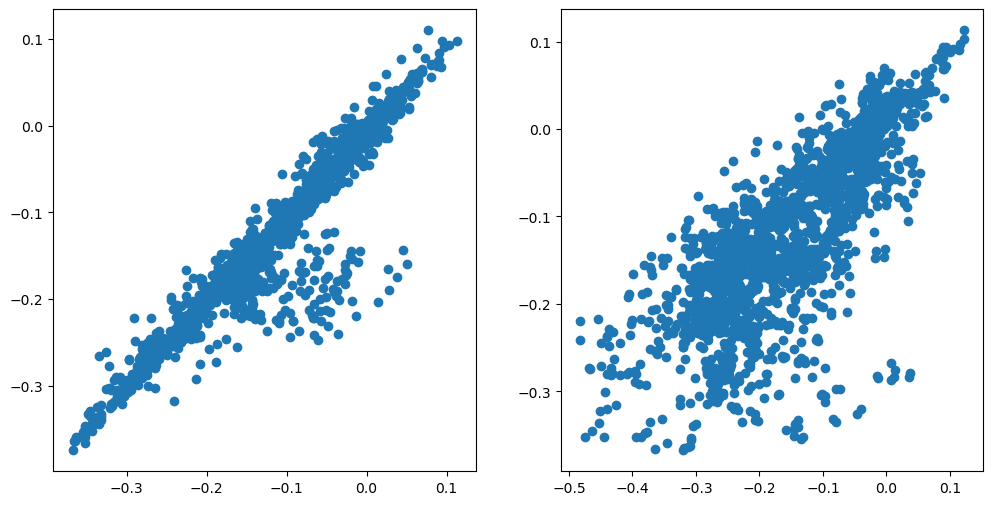

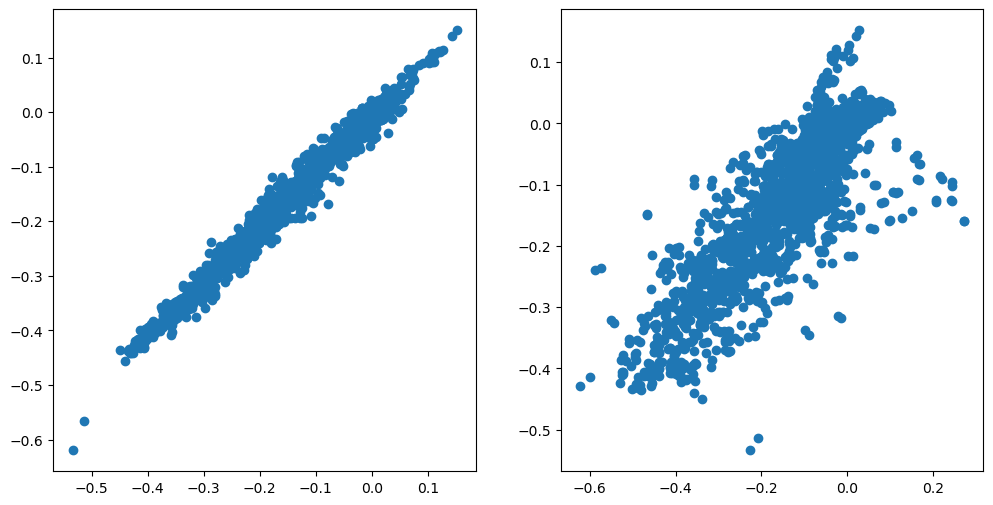

In [ ]:
_, (f1,f2) = plt.subplots(ncols = 2, figsize = (12, 6))
plt.sca(f1)
plt.scatter(stargetL, scomputedL)
plt.sca(f2)
plt.scatter(srefL, stargetL)


_, (f1,f2) = plt.subplots(ncols = 2, figsize = (12, 6))
plt.sca(f1)
plt.scatter(stargetC, scomputedC)
plt.sca(f2)
plt.scatter(srefC, stargetC)